In [1]:
import gensim
from gensim import corpora
from gensim import models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import numpy as np
import random
from glob import glob
from string import punctuation

import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
from dateutil import parser
import numpy as np
from tqdm import tqdm

from nltk.tokenize import TreebankWordTokenizer

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /Users/anne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
print(f"Your gensim version is {gensim.__version__}. This notebook assumes that you have version 4.0 or higher. If not, please upgrade.")
assert int(gensim.__version__[0])>=4

print(f"Your pyLDAvis version is {pyLDAvis.__version__}. This notebook assumes that you have version 3.0 or higher. If not, please upgrade.")
assert int(pyLDAvis.__version__[0])>=3

Your gensim version is 4.1.2. This notebook assumes that you have version 4.0 or higher. If not, please upgrade.
Your pyLDAvis version is 3.3.1. This notebook assumes that you have version 3.0 or higher. If not, please upgrade.


/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LDA is probabilistic method. As a consequence, you may find slight variations in results for different runs of the model. To make sure our findings are reproducable, we have to set a seed. In addition, we have to use `distributed=False` to get reproducable findings. 

In [4]:
random.seed(2022)
np.random.seed(2022)

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
## load data
PATH = 'path/to/folder/with/articles' #use the data that we've also worked with in week 2

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
RANDOM_N = 2000

## Helper function to read in the data. 
# Don't panic if you do not understand each line of code; try to follow along--but we do not expect you to write such helper functions yourself from scratch

def read_data(listofoutlets, RANDOM_N):
    date = []
    title = []
    outlets = []
    texts = []
    for outlet in listofoutlets:
        
        for file in random.choices(glob(f'{PATH}/*/{outlet}/*'), k=RANDOM_N):
            date.append(file.split('--')[-2])
            title.append(file.split('--')[-1])
            with open(file) as f:
                texts.append(f.read())
                outlets.append(outlet)
    return date, title, texts, outlets

dates, title, texts, outlets = read_data(['Infowars'], RANDOM_N)

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
len(texts)

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2000

In [8]:
texts[0][:500]

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'No society should function with this level of inequality (with the possible exception of one of those prison planets in a Star Wars movie). Sixty-three percent of Americans cant afford a $500 emergency. Yet Amazon head Jeff Bezos is now worth a record $141 billion. He could literally end world hunger for multiple years and still have more money left over than he could ever spend on himself.\n\nWorldwide, one in 10 people only make $2 a day. Do you know how long it would take one of those people to'

In [9]:
texts_clean = [text.lower() for text in texts]
texts_clean=[" ".join(text.split()) for text in texts_clean]  #remove dubble spaces
texts_clean = ["".join([l for l in text if l not in punctuation]) for text in texts_clean] #remove punctuaction
texts_clean[0][:500]

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'no society should function with this level of inequality with the possible exception of one of those prison planets in a star wars movie sixtythree percent of americans cant afford a 500 emergency yet amazon head jeff bezos is now worth a record 141 billion he could literally end world hunger for multiple years and still have more money left over than he could ever spend on himself worldwide one in 10 people only make 2 a day do you know how long it would take one of those people to make the sam'

## manually removing stopwords

In [10]:
mystopwords = set(stopwords.words('english')) # use default NLTK stopword list; alternatively:
# mystopwords = set(open('mystopwordfile.txt').readlines())  #read stopword list from a textfile with one stopword per line
texts_clean = [" ".join(word for word in text.split() if word not in mystopwords) for text in texts_clean]
texts_clean[0][:500]

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'society function level inequality possible exception one prison planets star wars movie sixtythree percent americans cant afford 500 emergency yet amazon head jeff bezos worth record 141 billion could literally end world hunger multiple years still money left could ever spend worldwide one 10 people make 2 day know long would take one people make amount jeff bezos 193 million years buy singleply toilet paper put simply cannot comprehend level inequality current world even nation shouldnt riots s'

## Tokenize texts

In [11]:
tokenized_texts_clean = [TreebankWordTokenizer().tokenize(text) for text in texts_clean ] # tokenize texts; convert all strings to a list of tokens
tokenized_texts_clean[0][:500]

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['society',
 'function',
 'level',
 'inequality',
 'possible',
 'exception',
 'one',
 'prison',
 'planets',
 'star',
 'wars',
 'movie',
 'sixtythree',
 'percent',
 'americans',
 'cant',
 'afford',
 '500',
 'emergency',
 'yet',
 'amazon',
 'head',
 'jeff',
 'bezos',
 'worth',
 'record',
 '141',
 'billion',
 'could',
 'literally',
 'end',
 'world',
 'hunger',
 'multiple',
 'years',
 'still',
 'money',
 'left',
 'could',
 'ever',
 'spend',
 'worldwide',
 'one',
 '10',
 'people',
 'make',
 '2',
 'day',
 'know',
 'long',
 'would',
 'take',
 'one',
 'people',
 'make',
 'amount',
 'jeff',
 'bezos',
 '193',
 'million',
 'years',
 'buy',
 'singleply',
 'toilet',
 'paper',
 'put',
 'simply',
 'can',
 'not',
 'comprehend',
 'level',
 'inequality',
 'current',
 'world',
 'even',
 'nation',
 'shouldnt',
 'riots',
 'streets',
 'every',
 'day',
 'shouldnt',
 'collapsing',
 'look',
 'outside',
 'streets',
 'arent',
 'fire',
 'one',
 'running',
 'naked',
 'screaming',
 'usually',
 'look',
 'like',
 'ev

## prepare the corpus for topic modelling

In [12]:
raw_m1 = tokenized_texts_clean
id2word_m1 = corpora.Dictionary(raw_m1)   # assign a token_id to each word
ldacorpus_m1 = [id2word_m1.doc2bow(text) for text in raw_m1] 

lda_m1 = models.LdaModel(ldacorpus_m1, id2word=id2word_m1, num_topics=10)
lda_m1.print_topics()

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.014*"trump" + 0.008*"said" + 0.008*"people" + 0.007*"president" + 0.004*"would" + 0.004*"news" + 0.004*"white" + 0.004*"also" + 0.003*"house" + 0.003*"fbi"'),
 (1,
  '0.011*"trump" + 0.007*"president" + 0.006*"said" + 0.005*"people" + 0.004*"one" + 0.004*"like" + 0.003*"also" + 0.003*"clinton" + 0.003*"news" + 0.003*"told"'),
 (2,
  '0.006*"trump" + 0.005*"one" + 0.005*"people" + 0.004*"president" + 0.004*"us" + 0.003*"said" + 0.003*"even" + 0.003*"new" + 0.003*"infowars" + 0.003*"cnn"'),
 (3,
  '0.010*"trump" + 0.007*"said" + 0.006*"president" + 0.005*"us" + 0.005*"people" + 0.004*"one" + 0.004*"percent" + 0.003*"white" + 0.003*"would" + 0.003*"democrats"'),
 (4,
  '0.007*"trump" + 0.007*"said" + 0.006*"president" + 0.005*"would" + 0.004*"one" + 0.003*"also" + 0.003*"state" + 0.003*"house" + 0.003*"people" + 0.003*"former"'),
 (5,
  '0.011*"said" + 0.004*"trump" + 0.004*"people" + 0.004*"media" + 0.004*"state" + 0.003*"president" + 0.003*"two" + 0.003*"also" + 0.003*"school"

### Use TFidF instead of word counts

In [13]:
ldacorpus_m2 = ldacorpus_m1 # reuse corpus from Model 1 
id2word_m2 = id2word_m1 # and thus, also use id2word-mapping

tfidfcorpus_m2 = models.TfidfModel(ldacorpus_m2)

lda_m2 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m2[ldacorpus_m2],id2word=id2word_m2,num_topics=10)
lda_m2.print_topics(num_words=5)

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.001*"trump" + 0.001*"said" + 0.001*"president" + 0.001*"kavanaugh" + 0.001*"percent"'),
 (1,
  '0.001*"trump" + 0.001*"said" + 0.001*"president" + 0.001*"clinton" + 0.001*"students"'),
 (2,
  '0.001*"trump" + 0.001*"white" + 0.001*"gun" + 0.001*"said" + 0.001*"house"'),
 (3,
  '0.001*"trump" + 0.001*"jones" + 0.001*"president" + 0.001*"alex" + 0.001*"white"'),
 (4,
  '0.001*"jones" + 0.001*"trump" + 0.001*"alex" + 0.001*"new" + 0.001*"said"'),
 (5,
  '0.001*"trump" + 0.001*"border" + 0.001*"president" + 0.001*"said" + 0.001*"democrats"'),
 (6,
  '0.001*"trump" + 0.001*"democrats" + 0.001*"president" + 0.001*"said" + 0.001*"mueller"'),
 (7,
  '0.001*"trump" + 0.001*"media" + 0.001*"jones" + 0.001*"infowars" + 0.001*"people"'),
 (8,
  '0.001*"trump" + 0.001*"infowars" + 0.001*"kavanaugh" + 0.001*"president" + 0.001*"would"'),
 (9,
  '0.001*"trump" + 0.001*"white" + 0.001*"cnn" + 0.001*"president" + 0.001*"people"')]

### Using N-grams as features

In [14]:
documents_bigrams = [["_".join(tup) for tup in nltk.ngrams(text.split(),2)] for text in texts_clean] # creates bigrams
documents_bigrams[0][:500] # inspect the results...

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['society_function',
 'function_level',
 'level_inequality',
 'inequality_possible',
 'possible_exception',
 'exception_one',
 'one_prison',
 'prison_planets',
 'planets_star',
 'star_wars',
 'wars_movie',
 'movie_sixtythree',
 'sixtythree_percent',
 'percent_americans',
 'americans_cant',
 'cant_afford',
 'afford_500',
 '500_emergency',
 'emergency_yet',
 'yet_amazon',
 'amazon_head',
 'head_jeff',
 'jeff_bezos',
 'bezos_worth',
 'worth_record',
 'record_141',
 '141_billion',
 'billion_could',
 'could_literally',
 'literally_end',
 'end_world',
 'world_hunger',
 'hunger_multiple',
 'multiple_years',
 'years_still',
 'still_money',
 'money_left',
 'left_could',
 'could_ever',
 'ever_spend',
 'spend_worldwide',
 'worldwide_one',
 'one_10',
 '10_people',
 'people_make',
 'make_2',
 '2_day',
 'day_know',
 'know_long',
 'long_would',
 'would_take',
 'take_one',
 'one_people',
 'people_make',
 'make_amount',
 'amount_jeff',
 'jeff_bezos',
 'bezos_193',
 '193_million',
 'million_years',
 'ye

In [15]:
# maybe we want both unigrams and bigrams in the feature set?
documents_uniandbigrams = []
for a,b in zip([text.split() for text in texts_clean],documents_bigrams):
    documents_uniandbigrams.append(a + b)

#and let's inspect the outcomes again.
documents_uniandbigrams[0]

len(documents_uniandbigrams[0]),len(documents_bigrams[0]),len(texts_clean[0].split())

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2083, 1041, 1042)

In [16]:
id2word_m3 = corpora.Dictionary(documents_uniandbigrams)
id2word_m3.filter_extremes(no_below=5, no_above=0.5)

ldacorpus_m3 = [id2word_m3.doc2bow(text) for text in documents_uniandbigrams]
tfidfcorpus_m3 = models.TfidfModel(ldacorpus_m3)

lda_m3 = models.ldamodel.LdaModel(corpus=tfidfcorpus_m3[ldacorpus_m3],id2word=id2word_m3,num_topics=10)
lda_m3.print_topics(num_words=5)

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.001*"trump" + 0.001*"people" + 0.001*"school" + 0.001*"media" + 0.001*"said"'),
 (1,
  '0.001*"trump" + 0.001*"president" + 0.001*"cnn" + 0.001*"infowars" + 0.001*"investigation"'),
 (2,
  '0.002*"trump" + 0.001*"clinton" + 0.001*"school" + 0.001*"said" + 0.001*"media"'),
 (3,
  '0.001*"trump" + 0.001*"president" + 0.001*"democrats" + 0.001*"said" + 0.001*"american"'),
 (4,
  '0.001*"trump" + 0.001*"infowars" + 0.001*"said" + 0.001*"would" + 0.001*"president"'),
 (5,
  '0.001*"trump" + 0.001*"border" + 0.001*"democrats" + 0.001*"infowars" + 0.001*"said"'),
 (6,
  '0.001*"trump" + 0.001*"president" + 0.001*"paul" + 0.001*"alex" + 0.001*"jones"'),
 (7,
  '0.001*"trump" + 0.001*"border" + 0.001*"president" + 0.001*"us" + 0.001*"caravan"'),
 (8,
  '0.001*"trump" + 0.001*"president" + 0.001*"cnn" + 0.001*"border" + 0.001*"jones"'),
 (9,
  '0.001*"trump" + 0.001*"said" + 0.001*"fbi" + 0.001*"comey" + 0.001*"people"')]

# 2. Model evaluation

In [17]:
# NB: CoherenceModel is only available in newer versions of gensim.
# if it's not available, consider upgrading with `pip3 install gensim -upgrade`


#The greater the number, the better is coherence score

cm1 = models.CoherenceModel(model=lda_m1, corpus=ldacorpus_m1 , dictionary=id2word_m1, coherence='u_mass')  
ch1 = cm1.get_coherence()
cm2 = models.CoherenceModel(model=lda_m2, corpus=ldacorpus_m2, dictionary= id2word_m2, coherence='u_mass')  
ch2 = cm2.get_coherence()
#cm3 = models.CoherenceModel(model=lda_m3, corpus=ldacorpus_m3, coherence='u_mass')
cm3 = models.CoherenceModel(model=lda_m3, corpus=tfidfcorpus_m3[ldacorpus_m3], dictionary= id2word_m3, coherence='u_mass')
ch3 = cm3.get_coherence()

print(f"Coherence of naive model = {ch1}\nCoherence of tfidf model = {ch2}\nCoherence of bigram and unigram model = {ch3}")

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence of naive model = -1.3941236703292463
Coherence of tfidf model = -1.9551697622809925
Coherence of bigram and unigram model = -2.010423200607849


In [18]:
lda_m2_bad = models.LdaModel(tfidfcorpus_m2[ldacorpus_m2],id2word=id2word_m2, num_topics=10,iterations=1)
print(models.CoherenceModel(model=lda_m2_bad, corpus=tfidfcorpus_m2[ldacorpus_m2], coherence='u_mass').get_coherence())

#lda_m2_good = models.LdaModel(tfidfcorpus_m4[ldacorpus_m4], id2word=id2word_m4, num_topics=10,iterations=50, passes=5)
#print(models.CoherenceModel(model=lda_m4_good, corpus=tfidfcorpus_m4[ldacorpus_m4], coherence='u_mass').get_coherence())

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-1.7992510605227316


In [19]:
lda_m2_good = models.LdaModel(tfidfcorpus_m2[ldacorpus_m2],id2word=id2word_m2, num_topics=10,iterations=50, passes=5)
print(models.CoherenceModel(model=lda_m2_good, corpus=tfidfcorpus_m2[ldacorpus_m2], coherence='u_mass').get_coherence())

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-5.341582177019141


In [20]:
lda_m2_good.top_topics(tfidfcorpus_m2[ldacorpus_m2])

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[([(0.0013752815, 'trump'),
   (0.0011003612, 'media'),
   (0.0009929175, 'cnn'),
   (0.00091347087, 'school'),
   (0.00089411234, 'students'),
   (0.00087874103, 'said'),
   (0.0008710116, 'news'),
   (0.00082185847, 'political'),
   (0.00080500956, 'president'),
   (0.0008034197, 'people'),
   (0.00079181907, 'would'),
   (0.0007853239, 'democratic'),
   (0.00077461265, 'party'),
   (0.00075617543, 'us'),
   (0.0007560248, 'infowars'),
   (0.00072411785, 'states'),
   (0.00072134286, 'democrats'),
   (0.00070869573, 'facebook'),
   (0.000700899, 'percent'),
   (0.0007000634, 'press')],
  -1.783925539582378),
 ([(0.0019972995, 'fbi'),
   (0.0016216711, 'trump'),
   (0.0013109433, 'campaign'),
   (0.0011929685, 'investigation'),
   (0.0011481525, 'kavanaugh'),
   (0.0011350731, 'house'),
   (0.0010814243, 'said'),
   (0.0010611967, 'clinton'),
   (0.0009987702, 'general'),
   (0.0009967936, 'facebook'),
   (0.0009676572, 'president'),
   (0.00096286804, 'former'),
   (0.0009498715, '20

## Visualize

In [21]:
vis_data = gensimvis.prepare(lda_m2,ldacorpus_m2,id2word_m2)
pyLDAvis.display(vis_data)

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## plot over time

In [22]:
## convert back to df

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
all_topics = lda_m2.get_document_topics(ldacorpus_m2, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)
all_topics_df.head()

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9
0,0.137749,0.220468,0.275056,0.000111,0.075643,0.049155,0.011372,0.216257,0.000111,0.014079
1,0.129307,0.121801,0.171363,0.000181,0.007153,0.000181,0.213775,0.261121,0.000181,0.094938
2,0.000251,0.000251,0.068813,0.744369,0.000251,0.000251,0.000251,0.185064,0.000251,0.000251
3,0.000614,0.000614,0.142423,0.000614,0.237909,0.000614,0.000614,0.615370,0.000614,0.000614
4,0.000759,0.000759,0.000759,0.000759,0.204961,0.000759,0.225370,0.564359,0.000759,0.000759


In [24]:
all_topics_df.rename(columns= { 0 : "topic_0", 1 : "topic_1", 2 : "topic_2", 3 : "topic_3",
4 : "topic_4", 5 : "topic_5", 6 : "topic_6", 7 : "topic_7", 8 : "topic_8", 9 : "topic_9" },inplace=True)
all_topics_df.head()

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.137749,0.220468,0.275056,0.000111,0.075643,0.049155,0.011372,0.216257,0.000111,0.014079
1,0.129307,0.121801,0.171363,0.000181,0.007153,0.000181,0.213775,0.261121,0.000181,0.094938
2,0.000251,0.000251,0.068813,0.744369,0.000251,0.000251,0.000251,0.185064,0.000251,0.000251
3,0.000614,0.000614,0.142423,0.000614,0.237909,0.000614,0.000614,0.615370,0.000614,0.000614
4,0.000759,0.000759,0.000759,0.000759,0.204961,0.000759,0.225370,0.564359,0.000759,0.000759


In [25]:
### create a df with the dates and orginal texts

meta = pd.DataFrame(zip(dates, texts))
meta.rename(columns = {0: "date", 1 : "texts"}, inplace=True)

meta.head()

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,texts
0,2018-07-28,No society should function with this level of ...
1,2018-04-27,President Trump pioneered new ways of campaign...
2,2018-02-09,"Former White House aide Rob Porter, who recent..."
3,2018-07-23,Sen. Rand Paul stated Monday that he intends t...
4,2018-02-05,California Rep. Adam Schiff suggested that an ...


In [26]:
### merge with the topic scores per document

final = pd.concat([meta, all_topics_df], axis=1)
final['id'] = final.index
final.head(3)

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,texts,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,id
0,2018-07-28,No society should function with this level of ...,0.137749,0.220468,0.275056,0.000111,0.075643,0.049155,0.011372,0.216257,0.000111,0.014079,0
1,2018-04-27,President Trump pioneered new ways of campaign...,0.129307,0.121801,0.171363,0.000181,0.007153,0.000181,0.213775,0.261121,0.000181,0.094938,1
2,2018-02-09,"Former White House aide Rob Porter, who recent...",0.000251,0.000251,0.068813,0.744369,0.000251,0.000251,0.000251,0.185064,0.000251,0.000251,2


In [27]:
### reshape to long format

long = pd.melt(final, id_vars=['id', 'date', 'texts'], value_vars=[f"topic_{i}" for i in range(0,10)])
long.rename(columns={"variable" : "topic_nr", "value" : "topic_score"}, inplace=True)
long.head(3)

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,date,texts,topic_nr,topic_score
0,0,2018-07-28,No society should function with this level of ...,topic_0,0.137749
1,1,2018-04-27,President Trump pioneered new ways of campaign...,topic_0,0.129307
2,2,2018-02-09,"Former White House aide Rob Porter, who recent...",topic_0,0.000251


In [28]:
# get data in right shape for plotting
import seaborn as sns

long['date'] = long['date'].map(pd.to_datetime)
#plotdf = long.groupby(['topic_nr',pd.Grouper(key='date', freq='M')]).sum().reset_index() 
#plotdf = long.groupby(['topic_nr',pd.Grouper(key='date', freq='M')]).mean().reset_index() #you may also opt for 'mean'

long['month'] = pd.DatetimeIndex(long['date']).month

/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/anne/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='month', ylabel='topic_score'>

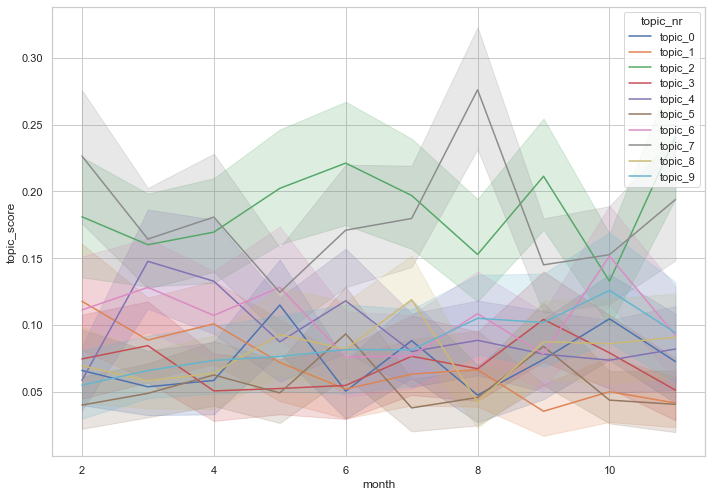

In [29]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid")

sns.lineplot(x="month", y="topic_score", hue="topic_nr", data=long)